# R modeling workflow overview

This code example outlines how to use DataRobot's R client to train and experiment with models. It also offers ideas for integrating DataRobot with other products via the API.

Specifically, you will:

- Create a project and run Autopilot.
- Experiment with feature lists, modeling algorithms, and hyperparameters.
- Choose the best model.
- Perform an in-depth evaluation of the selected model.
- Deploy a model into production in a few lines of code. This code example outlines how to use DataRobot's R client to train and experiment with models. It also offers ideas for integrating DataRobot with other products via the API.

## Data used for this example
This walkthrough uses a synthetic dataset that illustrates a credit card company’s anti-money laundering (AML) compliance program, with the intent of detecting the following money-laundering scenarios:

* A customer spends on the card, but overpays their credit card bill and seeks a cash refund for the difference.
* A customer receives credits from a merchant without offsetting transactions, and either spends the money or requests a cash refund from the bank.

A rule-based engine is in place to produce an alert when it detects potentially suspicious activity consistent with the scenarios above. The engine triggers an alert whenever a customer requests a refund of any amount. Small refund requests are included because they could be a money launderer’s way of testing the refund mechanism or trying to establish refund requests as a normal pattern for their account.

The target feature is `SAR`, suspicious activity reports. It indicates whether or not the alert resulted in an SAR after manual review by investigators, which means that this project is a binary classification problem. The unit of analysis is an individual alert, so the model will be built on the alert level. Each alert will get a score ranging from 0 to 1, indicating the probability of being an alert leading to an SAR. The data consists of a mixture of numeric, categorical, and text data.

## Setup

The following sections outline the required libraries and connection methods to begin building models with Autopilot.

### Import Libraries

In [5]:
library(dplyr)
library(ggplot2)
library(datarobot)

### Connect to DataRobot
To use R with DataRobot you first need to establish a connection between your machine and the DataRobot instance. Read more about different options for [connecting to DataRobot from the client](https://docs.datarobot.com/en/docs/api/api-quickstart/api-qs.html).

In [ ]:
datarobot::ConnectToDataRobot(configPath = '<file-path-to-drconfig.yaml>')

### Upload a dataset

In [46]:
# Set to the location of the training data via a local file or URL 
# Sample file location: '/Users/myuser/Downloads/DR_Demo_AML_Alert.csv'
dataset_file_path <- "https://s3.amazonaws.com/datarobot_public_datasets/DR_Demo_AML_Alert.csv"
training_data <- utils::read.csv(dataset_file_path)
test_data <- training_data[-c(2)]
head(training_data)

ALERT SAR kycRiskScore income tenureMonths creditScore state nbrPurchases90d
1 1     0   3            110300  5           757         PA    10             
2 1     0   2            107800  6           715         NY    22             
3 1     0   1             74000 13           751         MA     7             
4 1     0   0             57700  1           659         NJ    14             
5 1     0   1             59800  3           709         PA    54             
6 1     0   1             43500 11           717         CT    18             
  avgTxnSize90d totalSpend90d ⋯ indCustReqRefund90d totalRefundsToCust90d
1 153.80        1538.00       ⋯ 1                     45.82              
2   1.59          34.98       ⋯ 1                     67.40              
3  57.64         403.48       ⋯ 1                    450.69              
4  29.52         413.28       ⋯ 1                     71.43              
5 115.77        6251.58       ⋯ 1                   2731.39              
6  36.11         649.98       ⋯ 1                     26.66              
  nbrPaymentsCashLike90d maxRevolveLine indOwnsHome nbrInquiries1y
1 5                       6000          0           3             
2 0                      10000          1           3             
3 0                      10000          0           3             
4 0                       8000          1           5             
5 3                       7000          1           1             
6 0                       9000          0           2             
  nbrCollections3y nbrWebLogins90d nbrPointRed90d PEP
1 0                 6              1              0  
2 0                87              0              0  
3 0                 6              0              0  
4 0                 7              2              0  
5 0                 8              1              0  
6 1                 3              2              0

## Create a project and train models with Autopilot

In [ ]:
# Create a project by uploading data. This will take a few minutes.
project <- SetupProject(dataSource = training_data, projectName = "SAR Detection", maxWait = 60 * 60)

# Set the project target and initiate Autopilot
SetTarget(project,
  target = "SAR")

# Block execution until Autopilot is complete
WaitForAutopilot(project)
# The `WaitForAutopilot()` function forces the R Kernel to wait until DataRobot has finished modeling before executing the next series of commands.

# Open the project's Leaderboard to monitor the progress in UI.
ViewWebProject("project-id") # Provide the project ID

### Retrieve and review results from the Leaderboard

In [ ]:
# Use the `ListModels()` function to retrieve a list of all the trained DataRobot models for a specified project.
ListModels(project)

In [ ]:
# Retrive the model DataRobot recommends for deployment
model <- GetRecommendedModel(project, type = RecommendedModelType$RecommendedForDeployment)

# Get a model's blueprint
GetModelBlueprintChart(project, model$modelId)

## Experiment to get better results

When you run a project using Autopilot, DataRobot first creates blueprints based on the characteristics of your data and puts them in the Repository. Then, it chooses a subset from these to train; when training completes, these are the blueprints you’ll find on the Leaderboard. After the Leaderboard is populated, it can be useful to train some of those blueprints that DataRobot skipped. For example, you can try a more complex Keras blueprint like Keras Residual AutoInt Classifier using Training Schedule (3 Attention Layers with 2 Heads, 2 Layers: 100, 100 Units). In some cases, you may want to directly access the trained model through R and retrain it with a different feature list or tune its hyperparameters.

### Find blueprints trained for the project from the Leaderboard

In [ ]:
modelsInLeaderboard <- ListModels(project)
modelsInLeaderboard_df <- as.data.frame(modelsInLeaderboard)

### Train a model using a different feature list

In [ ]:
for (i in 1:length(modelsInLeaderboard_df)){
    job <- RequestNewModel(project, modelsInLeaderboard_df[[i]])
    WaitForJobToComplete(project, job, maxWait=600)
}

### Tune hyperparameters for a model

In [ ]:
StartTuningSession(model)

### Select the top-performing model

In [ ]:
# Use the `ListModels()` function to retrieve a list of all the trained DataRobot models for a specified project
ListModels(project)

# Retrieve the model DataRobot recommends for deployment
model <- GetRecommendedModel(project, type = RecommendedModelType$RecommendedForDeployment)

### Calculate Feature Impact

In [19]:
# Select a model from the Leaderboard:
model <- GetModel(project, model$modelId)

# Retrieve the top 10 most impactful features:
feature_impact <- GetFeatureImpact(model)
feature_impact <- feature_impact[order(-feature_impact$impactNormalized), ] %>% slice(1:10)
feature_impact

featureName            impactNormalized impactUnnormalized redundantWith
1  totalMerchCred90d      1.00000000       0.149085915        NA           
2  nbrCustReqRefunds90d   0.51163007       0.076276837        NA           
3  totalRefundsToCust90d  0.42568163       0.063463135        NA           
4  totalSpend90d          0.14489628       0.021601995        NA           
5  totalPaymentAmt90d     0.12352879       0.018416403        NA           
6  avgTxnSize90d          0.06139331       0.009152878        NA           
7  overpaymentInd90d      0.05853019       0.008726026        NA           
8  csrNotes               0.05485649       0.008178330        NA           
9  income                 0.03974456       0.005925353        NA           
10 nbrPaymentsCashLike90d 0.03641069       0.005428321        NA

### Train a model with a new feature list

In [ ]:
# Create a feature list using the top 10 features:
top10_feat_list <- CreateFeaturelist(project, "Top 10 Features Across Models",
                                     feature_impact$featureName)

# Retrain models using the new feature list:
StartNewAutoPilot(project, top10_feat_list$featurelistId, 
                  mode = AutopilotMode$Quick)

### Select the best-performing model

In [ ]:
model <- ListModels(project)[[1]]
model

## In-depth model evaluation

### Retrieve and plot the ROC curve

In [24]:
roc <- GetRocCurve(model,
                   source = 'validation')
roc_df <- roc$rocPoints
head(roc_df)

accuracy f1Score    falseNegativeScore trueNegativeScore truePositiveScore
1 0.897500 0.00000000 164                1436               0               
2 0.898125 0.01212121 163                1436               1               
3 0.900625 0.07017544 158                1435               6               
4 0.903750 0.12500000 153                1435              11               
5 0.904375 0.14525140 151                1434              13               
6 0.905000 0.18279570 147                1431              17               
  falsePositiveScore trueNegativeRate falsePositiveRate truePositiveRate
1 0                  1.0000000        0.0000000000      0.000000000     
2 0                  1.0000000        0.0000000000      0.006097561     
3 1                  0.9993036        0.0006963788      0.036585366     
4 1                  0.9993036        0.0006963788      0.067073171     
5 2                  0.9986072        0.0013927577      0.079268293     
6 5                  0.9965181        0.0034818942      0.103658537     
  matthewsCorrelationCoefficient positivePredictiveValue
1 0.00000000                     0.0000000              
2 0.07399989                     1.0000000              
3 0.16493143                     0.8571429              
4 0.23334555                     0.9166667              
5 0.24509809                     0.8666667              
6 0.26091604                     0.7727273              
  negativePredictiveValue threshold fractionPredictedAsPositive
1 0.8975000               1.0000000 0.000000                   
2 0.8980613               0.8840490 0.000625                   
3 0.9008161               0.8461373 0.004375                   
4 0.9036524               0.8384385 0.007500                   
5 0.9047319               0.8311916 0.009375                   
6 0.9068441               0.8193629 0.013750                   
  fractionPredictedAsNegative liftPositive liftNegative
1 1.000000                    0.000000     1.000000    
2 0.999375                    9.756098     1.000625    
3 0.995625                    8.362369     1.003695    
4 0.992500                    8.943089     1.006855    
5 0.990625                    8.455285     1.008058    
6 0.986250                    7.538803     1.010411

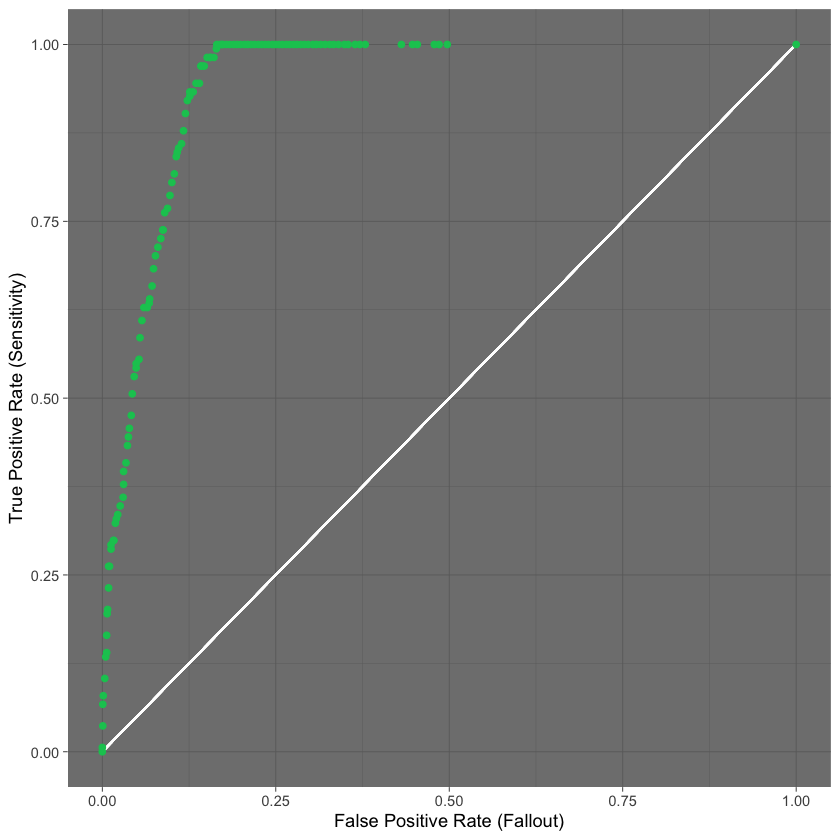

In [25]:
dr_roc_green <- '#03c75f'
ggplot(data = roc_df,
       mapping = aes(x = falsePositiveRate,
                     y = truePositiveRate)) +
    geom_segment(mapping = aes(x = 0, xend = 1, y = 0, yend = 1), color = "white") +
    geom_point(color = dr_roc_green) +
    xlab("False Positive Rate (Fallout)") + 
    ylab("True Positive Rate (Sensitivity)") + 
    theme_dark()

### Retrieve and plot Feature Impact

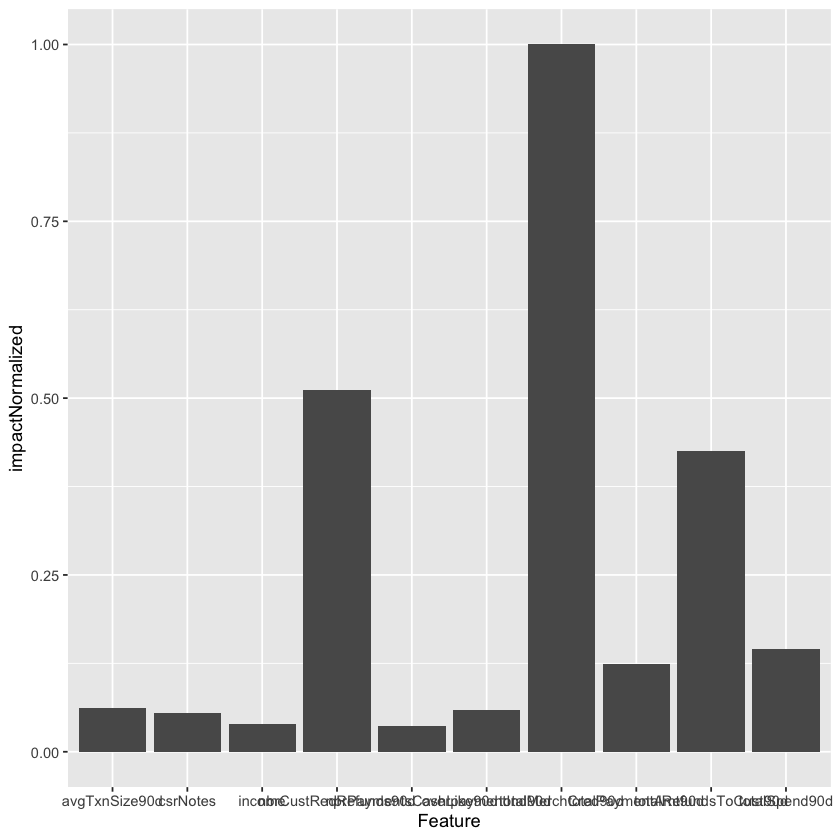

In [20]:
# Retrieve the top 10 most impactful features:
feature_impact <- GetFeatureImpact(model)
feature_impact <- feature_impact[order(-feature_impact$impactNormalized),] %>% slice(1:10)

# Create plot of top 10 features based on Feature Impact
ggplot(data = feature_impact,
       mapping = aes(
           x = featureName, 
           y = impactNormalized)) + 
    geom_col() +
    labs(x = "Feature")

### Score data before deployment

In [ ]:
test_data <- training_data[ -c(2) ]
head(test_data)

In [ ]:
# Uploading the testing dataset
scoring <- UploadPredictionDataset(project, dataSource = test_data)

# Requesting prediction
predict_job_id <- RequestPredictions(project, modelId = model$modelId, datasetId = scoring$id)

# Grabbing predictions
predictions_prob <- GetPredictions(project, predictId = predict_job_id, type = "probability")
head(predictions_prob)

### Compute Prediction Explanations

In [ ]:
GetPredictionExplanations(model, test_data)

## Deploy a model

After identifying the best-performing models, you can deploy them and use DataRobot's REST API to [make HTTP requests and return predictions](https://docs.datarobot.com/en/docs/predictions/api/dr-predapi.html). You can also configure [batch prediction jobs](https://docs.datarobot.com/en/docs/predictions/batch/batch-prediction-api/index.html) to write back into your environment of choice.

Once deployed, access monitoring capabilities such as:

- [Service health](https://docs.datarobot.com/en/docs/mlops/monitor/service-health.html)
- [Prediction accuracy](https://docs.datarobot.com/en/docs/mlops/monitor/deploy-accuracy.html)
- [Model retraining](https://docs.datarobot.com/en/docs/mlops/manage-mlops/set-up-auto-retraining.html)

In [ ]:
prediction_server <- ListPredictionServers()[[1]]

deployment <- CreateDeployment(model, 
                               label = 'New Deployment', 
                               description = 'A new deployment',
                               defaultPredictionServerId = prediction_server$id)
deployment